# Sentiment Classification Model 2

 Trained on IMDB dataset which is rebalanced to make better predictions on the WW2 bunker reviews.

### 1. Import Dependencies

In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    Trainer, 
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support




### 2. Load Data

In [2]:
df = pd.read_pickle("../data/processed/processed_movie_reviews.pkl")
df.head()

,review,sentiment,clean_text,tokens
0,One of the other reviewers has mentioned that ...,1,One of the other reviewers has mentioned that ...,"{'input_ids': [101, 2028, 1997, 1996, 2060, 15..."
1,A wonderful little production. <br /><br />The...,1,A wonderful little production. The filming tec...,"{'input_ids': [101, 1037, 6919, 2210, 2537, 10..."
2,I thought this was a wonderful way to spend ti...,1,I thought this was a wonderful way to spend ti...,"{'input_ids': [101, 1045, 2245, 2023, 2001, 10..."
3,Basically there's a family where a little boy ...,0,Basically there's a family where a little boy ...,"{'input_ids': [101, 10468, 2045, 1005, 1055, 1..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,Petter Mattei's Love in the Time of Money is a...,"{'input_ids': [101, 9004, 3334, 4717, 7416, 10..."


### 3. Prepare Train/Validation Splits

In [3]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["clean_text"], df["sentiment"], test_size=0.2, random_state=42
)

### 4. Create a Dataset Class

In [4]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist() if hasattr(texts, "tolist") else texts
        self.labels = labels.tolist() if hasattr(labels, "tolist") else labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }
        return item


### 5. Instansiate Tokenizer & Dataset

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)

df_train = pd.DataFrame({
    "clean_text": train_texts,
    "sentiment": train_labels
})

print(df_train.head())

                                              clean_text  sentiment
39087  That's what I kept asking myself during the ma...          0
30893  I did not watch the entire movie. I could not ...          0
45278  A touching love story reminiscent of In the Mo...          1
16398  This latter day Fulci schlocker is a totally a...          0
13653  First of all, I firmly believe that Norwegian ...          0


### Rebalance the Training Set

In [ ]:
# 2. Rebalance the training portion only
df_pos = df_train[df_train["sentiment"] == 1]
df_neg = df_train[df_train["sentiment"] == 0]

# Suppose you want to achieve a target ratio of 76% positive and 24% negative
target_ratio_pos = 0.75
target_ratio_neg = 0.25

total_samples = len(train_dataset)
n_pos = int(total_samples * target_ratio_pos)
n_neg = int(total_samples * target_ratio_neg)

df_pos_sample = df_pos.sample(n=min(n_pos, len(df_pos)), replace=(n_pos > len(df_pos)), random_state=42)
df_neg_sample = df_neg.sample(n=min(n_neg, len(df_neg)), replace=(n_neg > len(df_neg)), random_state=42)

train_df_rebalanced = pd.concat([df_pos_sample, df_neg_sample], ignore_index=True)
train_df_rebalanced = train_df_rebalanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Rebalanced training set size: {len(train_df_rebalanced)}")
print(f"Positive samples: {(train_df_rebalanced['sentiment'] == 1).sum()}")
print(f"Negative samples: {(train_df_rebalanced['sentiment'] == 0).sum()}")


Rebalanced training set size: 16666
Positive samples: 12666
Negative samples: 4000


In [12]:
rebalanced_texts = train_df_rebalanced["clean_text"].tolist()
rebalanced_labels = train_df_rebalanced["sentiment"].tolist()

train_dataset_rebalanced = SentimentDataset(rebalanced_texts, rebalanced_labels, tokenizer)


### 6. Initialize Model and Trainer

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="outputs2",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="logs",
    logging_steps=50,
    bf16 = True if torch.backends.mps.is_available() else False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_rebalanced,
    eval_dataset=val_dataset
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 7. Train

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.308200,0.424293
2,0.215000,0.558151
3,0.136400,0.783772


TrainOutput(global_step=6252, training_loss=0.22250311446838827, metrics={'train_runtime': 6007.415, 'train_samples_per_second': 8.323, 'train_steps_per_second': 1.041, 'total_flos': 3288756636472320.0, 'train_loss': 0.22250311446838827, 'epoch': 3.0})

In [ ]:
model = BertForSequenceClassification.from_pretrained("outputs2/checkpoint-6252")


# Re-initialize the Trainer with the same arguments but the loaded model:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_rebalanced,
    eval_dataset=val_dataset
)


In [27]:
val_preds = trainer.predict(val_dataset)


### Performance on Validation Set

In [ ]:
logits = val_preds.predictions
labels = val_preds.label_ids

# Argmax over logits to get predicted class (0 or 1)
preds = np.argmax(logits, axis=1)

accuracy = (preds == labels).mean()

acc = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

print(f"Accuracy:   {acc:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1:         {f1:.4f}")


Accuracy:   0.8611
Precision:  0.8092
Recall:     0.9478
F1:         0.8730


### Confusion Matrix of Validation Set

[[3835 1126]
 [ 263 4776]]


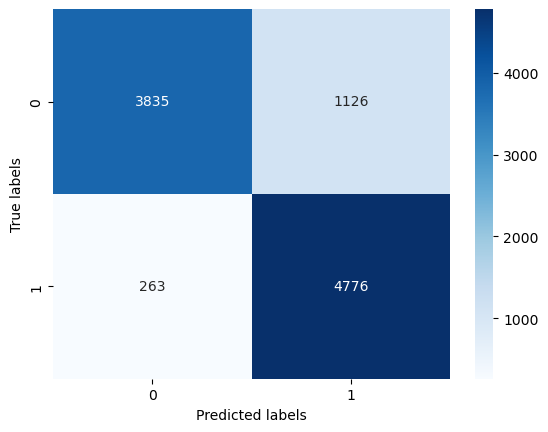

In [ ]:
# `labels` = ground-truth labels (0 or 1)
# `preds` = predicted labels (0 or 1)

cm = confusion_matrix(labels, preds)
print(cm)


ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
plt.show()



### 8. Evaluate

In [22]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.7837717533111572, 'eval_runtime': 267.2509, 'eval_samples_per_second': 37.418, 'eval_steps_per_second': 4.677, 'epoch': 3.0}


### 9. Predict on WWII Dataset

In [ ]:
model = BertForSequenceClassification.from_pretrained("outputs2/checkpoint-6252")  # Adjust to your checkpoint path
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

df_test = pd.read_pickle("../data/processed/bunker_test_set_tokenized.pkl")

class InferenceDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.texts = df["clean_text"].tolist()
        self.tokenizer = tokenizer
        self.max_length = 512  
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze()
        }

inference_dataset = InferenceDataset(df_test)

training_args = TrainingArguments(
    output_dir="outputs",
    per_device_eval_batch_size=8
)
trainer = Trainer(
    model=model,
    args=training_args
)

predictions_output = trainer.predict(inference_dataset)
logits = predictions_output.predictions  # shape: (num_samples, 2)

probs = F.softmax(torch.tensor(logits), dim=1).numpy()

# Neutral threshold
threshold = 0.9

# Map binary predictions into three classes:
final_preds = []
for p in probs:
    if p.max() < threshold:
        final_preds.append("neutral")
    elif p.argmax() == 1:
        final_preds.append("positive")
    else:
        final_preds.append("negative")

df_test["predicted_sentiment"] = final_preds

df_test = df_test[["clean_text", "manual_classification", "predicted_sentiment", "tokens"]]

df_test.to_csv("../data/processed/bunker_predictions.csv", index=False)
print("Predictions saved to data/processed/bunker_predictions.csv")


Predictions saved to data/processed/bunker_predictions.csv


### Distribution of Probabilities of Sentiment Classification

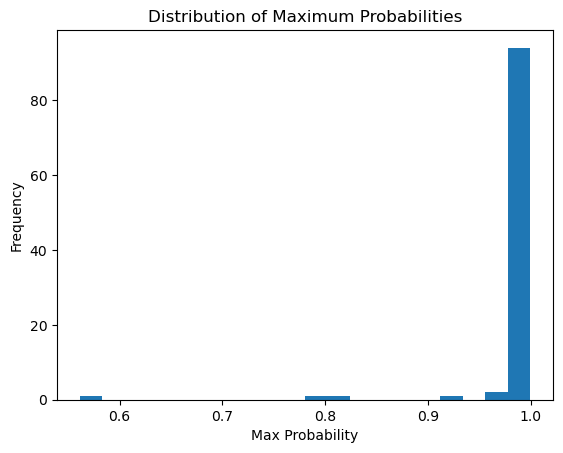

In [ ]:
max_probs = [p.max() for p in probs]
plt.hist(max_probs, bins=20)
plt.xlabel("Max Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Maximum Probabilities")
plt.show()


### Performance on WWII Sample dataset (100 reviews manually classified)

In [32]:
df_test = pd.read_csv("../data/processed/bunker_predictions.csv")

manual_labels = df_test["manual_classification"]
predicted_labels = df_test["predicted_sentiment"]

accuracy = accuracy_score(manual_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(manual_labels, predicted_labels, labels=["positive", "neutral", "negative"])
print("Confusion Matrix:")
print(cm)

report = classification_report(manual_labels, predicted_labels, labels=["positive", "neutral", "negative"])
print("Classification Report:")
print(report)


Accuracy: 0.7800
Confusion Matrix:
[[71  2  3]
 [10  1  3]
 [ 4  0  6]]
Classification Report:
              precision    recall  f1-score   support

    positive       0.84      0.93      0.88        76
     neutral       0.33      0.07      0.12        14
    negative       0.50      0.60      0.55        10

    accuracy                           0.78       100
   macro avg       0.56      0.54      0.52       100
weighted avg       0.73      0.78      0.74       100



In [ ]:
df_incorrect = df_test[df_test["manual_classification"] != df_test["predicted_sentiment"]]

df_incorrect.to_csv("incorrect_classifications.csv", index=False)
